In [1]:
import scipy.io as sco
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

 

---
__Order Imbalance (Imb_LOB)__
$$
\rho_t=\frac{V_t^b-V_t^a}{V_t^a+V_t^b} 
$$

``This is a measure of the buy versue sell pressure on an asset and contains predictive power on both the arrival rates of MOs, and the direction and size of future price movements``

In [2]:
class Fetchdata(object): 
    def __init__(self, test_period, ticker):
        self.test_period=test_period
        self.ticker=ticker
        
    def dTime(self,  x): 
        '''time stamp milliseconds from midnight at the start of the second'''
        H=str(int(x*0.001/3600))
        M=str(int((x*0.001/3600)%1*60))
        h='0'*(2-len(H))+H
        m='0'*(2-len(M))+M
        return '{}:{}'.format(h,m)
        
    def aveVol5(self, _period):
        '''past five days' aveVol'''
        d=sco.loadmat('./data/{}_{}.mat'.format(self.ticker, _period[0]))
        df=pd.DataFrame.from_dict(d['LOB'][0][0][2])
        df.columns=['dtime']
        df['dtime']=df['dtime'].apply(self.dTime)
        df[date[0]]=np.sum(d['LOB'][0][0][1][:,:2], axis=1).astype('int') 
        df=df[(df['dtime']>='09:30')&(df['dtime']<='16:00')]  
        df=df.groupby('dtime').sum()
        df.reset_index(inplace=True)
        
        for _ in _period[1:]:
            d=sco.loadmat('./data/{}_{}.mat'.format(self.ticker,_))
            t=pd.DataFrame.from_dict(d['LOB'][0][0][2])
            t.columns=['dtime']
            t['dtime']=t['dtime'].apply(self.dTime)
            t[_]=np.sum(d['LOB'][0][0][1][:,:2], axis=1).astype('int') 
            t=t[(t['dtime']>='09:30')&(t['dtime']<='16:00')]  
            t=t.groupby('dtime').sum()
            t.reset_index(inplace=True)
            df=pd.merge(df, t, on='dtime')
        df.set_index('dtime',inplace=True)   
        return  df.mean().mean()
    
    
    def fetchdata(self):
        for i in range(len(self.test_period)-5):
            avevol=self.aveVol5(self.test_period[i:i+5])
            AnalysisDate=self.test_period[i+5]
            data=sco.loadmat('./data/{}_{}.mat'.format(self.ticker, AnalysisDate))
            
            df=pd.DataFrame.from_dict(data['LOB'][0][0][2])  
            df.columns=['dtime']
            df['dtime']=AnalysisDate+' '+df['dtime'].apply(self.dTime)
            df['buyNum']=data['LOB'][0][0][0][:,0]; 
            df['sellNum']=data['LOB'][0][0][0][:,1] 
            df['buyVol']=data['LOB'][0][0][1][:,0]; 
            df['sellVol']=data['LOB'][0][0][1][:,1]  
            df['Vol']=df['buyVol']+df['sellVol']
            df['BuyPx1']=data['LOB'][0][0][3][:,0] *0.0001
            df['SellPx1']=data['LOB'][0][0][4][:,0] *0.0001
            df['BuyVol']=np.sum(data['LOB'][0][0][5][:,:20], axis=1).astype('int') 
            df['SellVol']=np.sum(data['LOB'][0][0][6][:,:20], axis=1).astype('int')
            df['Imb_LOB']=(df['BuyVol'] -df['SellVol'])/(df['BuyVol'] +df['SellVol']) 
            
            
            #time-comsuming part
            if i==0:
                self.df=pd.DataFrame(columns=list(df.columns)+['QRR', 'RVol'])
                ix=0
                for name, group in df.groupby('dtime'):
                    self.df.loc[ix]=[name,
                                     group.buyNum.sum(), 
                                     group.sellNum.sum(),
                                     group.buyVol.sum(), 
                                     group.sellVol.sum(),
                                     group.Vol.sum(),
                                     group.BuyPx1.tail(1).values[0],   
                                     group.SellPx1.tail(1).values[0],
                                     group.BuyVol.tail(1).values[0], 
                                     group.SellVol.tail(1).values[0],
                                     group.Imb_LOB.mean(),
                                     (group.Vol.sum()+self.df['Vol'].sum())/(avevol*(ix+1)),
                                     group.Vol.sum()/avevol]
                    ix+=1 
                self.df['mid']=0.5*(self.df['BuyPx1']+self.df['SellPx1'])
                self.df.set_index('dtime', inplace=True)
            else:
                t=pd.DataFrame(columns=list(df.columns)+['QRR', 'RVol'])
                ix=0
                for name, group in df.groupby('dtime'):
                    t.loc[ix]=[name,
                               group.buyNum.sum(), 
                               group.sellNum.sum(),
                               group.buyVol.sum(), 
                               group.sellVol.sum(),
                               group.Vol.sum(),
                               group.BuyPx1.tail(1).values[0],   
                               group.SellPx1.tail(1).values[0],
                               group.BuyVol.tail(1).values[0], 
                               group.SellVol.tail(1).values[0],
                               group.Imb_LOB.mean(),
                               (group.Vol.sum()+t['Vol'].sum())/(avevol*(ix+1)),
                               group.Vol.sum()/avevol]
                    ix+=1 
                t['mid']=0.5*(t['BuyPx1']+t['SellPx1'])
                t.set_index('dtime', inplace=True)
                self.df=pd.concat([self.df, t])
                
    def figPrice(self): 
        fig, ax=plt.subplots(figsize=(12,7))
        self.df['mid'].plot()  
        ax.spines['top'].set_visible(False) 
        ax.spines['right'].set_visible(False)
        plt.title('{} Price Dynamics \n\n\n'.format(self.ticker))
        plt.tight_layout()
        plt.savefig('./fig/price')
         
        
    def figImb_Lob(self): 
        fig, ax=plt.subplots(figsize=(12,7))
        self.df['Imb_LOB'].plot()  
        ax.spines['top'].set_visible(False) 
        ax.spines['right'].set_visible(False)
        plt.title('Limit Order Book: Order Imbalance \n\n\n')
        plt.tight_layout()
        plt.savefig('./fig/oimb')
         
         
    def figQRR(self):
        fig, ax=plt.subplots(figsize=(12,7))
        self.df['QRR'].plot()  
        ax.spines['top'].set_visible(False) 
        ax.spines['right'].set_visible(False)
        plt.title('Quantity Relative Ratio \n\n\n')
        plt.tight_layout()
        plt.savefig('./fig/qrr')
        
        
        
    def figVol(self):
        fig, ax=plt.subplots(figsize=(12,7))
        self.df['Vol'].plot()  
        ax.spines['top'].set_visible(False) 
        ax.spines['right'].set_visible(False)
        plt.title('Volume \n\n\n')
        plt.tight_layout()
        plt.savefig('./fig/vol')
        
    def figRVol(self):
        fig, ax=plt.subplots(figsize=(12,7))
        self.df['RVol'].plot()  
        ax.spines['top'].set_visible(False) 
        ax.spines['right'].set_visible(False)
        plt.title('Relative Volume \n\n\n')
        plt.tight_layout()
        plt.savefig('./fig/Rvol')

In [3]:
if __name__=="__main__": 
    ticker='VOD'
    date=['20141103','20141104','20141105','20141106','20141107', 
          '20141110', '20141111','20141112', '20141113','20141114',
          '20141117', '20141118','20141119', '20141120','20141121',
          '20141124']
    
    ins=Fetchdata(date, ticker)
    ins.fetchdata()

In [4]:
ins.df.head()

,buyNum,sellNum,buyVol,sellVol,Vol,BuyPx1,SellPx1,BuyVol,SellVol,Imb_LOB,QRR,RVol,mid
dtime,,,,,,,,,,,,,
20141110 09:30,10,8,10028,5750,15778,32.87,32.89,243108,103781,0.265175,8.789276,8.789276,32.880
20141110 09:31,11,11,7670,4337,12007,32.93,32.94,137453,121740,0.303243,7.738941,6.688607,32.935
20141110 09:32,4,3,3400,1300,4700,32.88,32.89,168596,134093,-0.005100,6.032020,2.618177,32.885
20141110 09:33,1,6,500,4000,4500,32.84,32.85,151009,133318,0.034482,5.150706,2.506765,32.845
20141110 09:34,11,1,3526,700,4226,32.86,32.87,191196,116374,0.092113,4.591391,2.354131,32.865


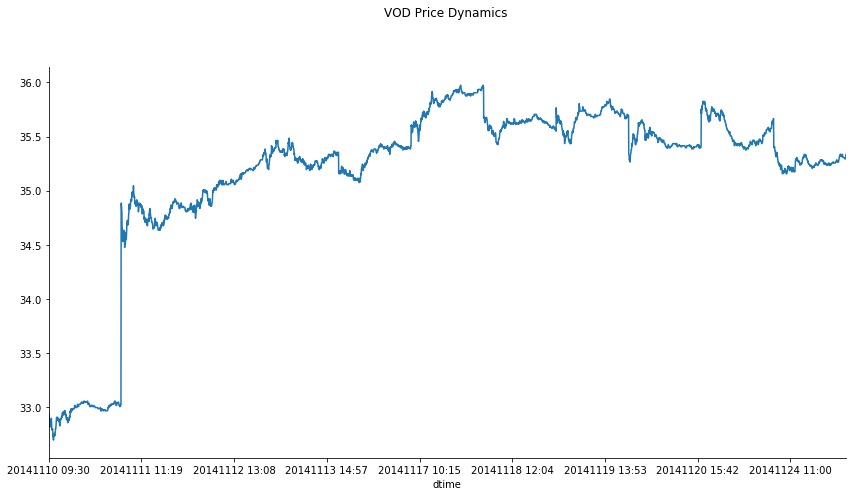

In [5]:
ins.figPrice() #diffusion process 

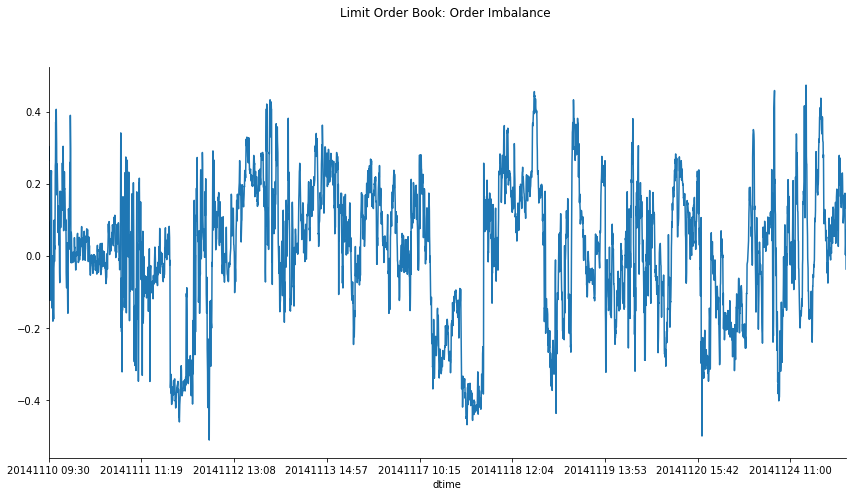

In [6]:
ins.figImb_Lob()  # mean-recersion (OU-process)

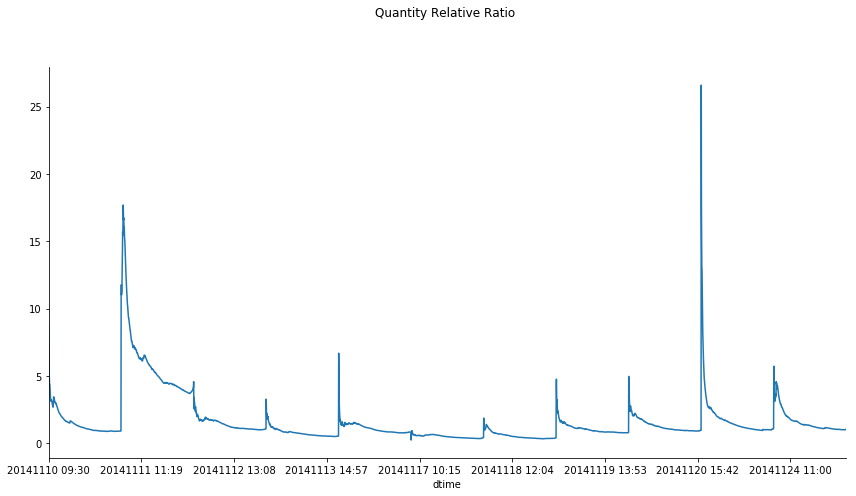

In [7]:
ins.figQRR() #exponentially distributed  

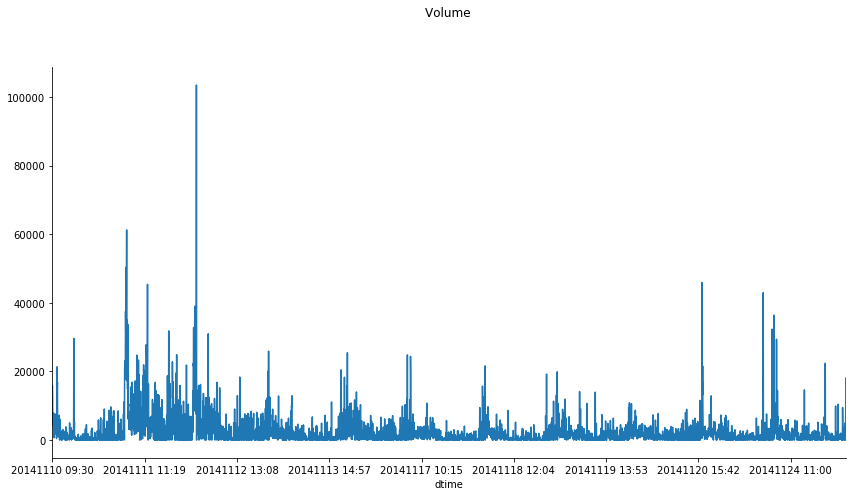

In [8]:
ins.figVol()  #mean-reversion (OU-process)

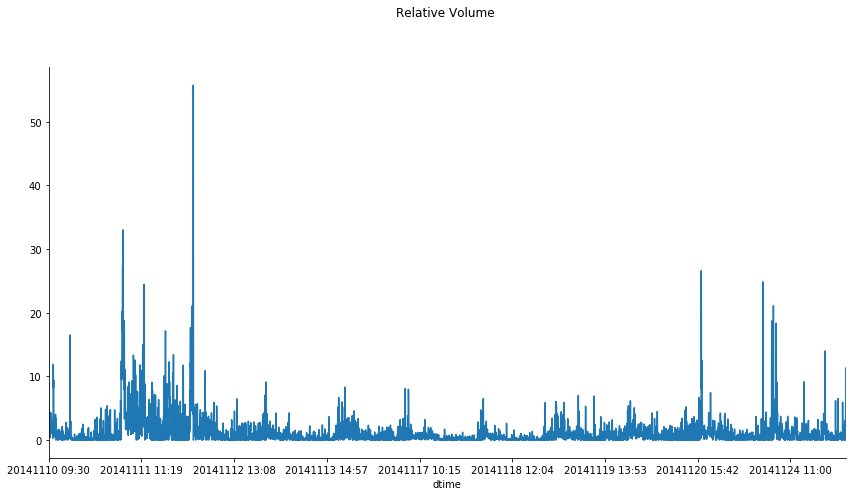

In [9]:
ins.figRVol()

---

---

__Prediction Power:__

- One day's time series' Info

---

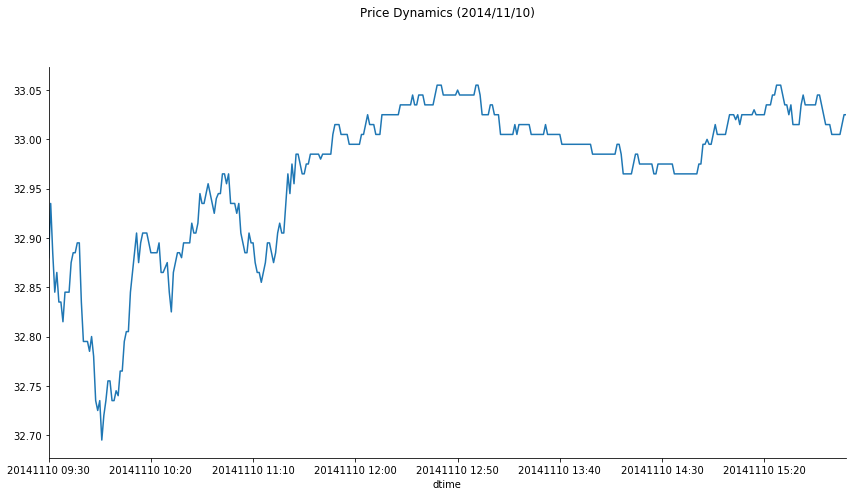

In [10]:
fig1, ax1=plt.subplots(figsize=(12,7))
ins.df['mid'][(ins.df.index>='20141110') & (ins.df.index<'20141111')].plot()
ax1.spines['top'].set_visible(False) 
ax1.spines['right'].set_visible(False)
plt.title('Price Dynamics (2014/11/10)\n\n\n') 
plt.tight_layout() 

plt.savefig('./fig/price_1')

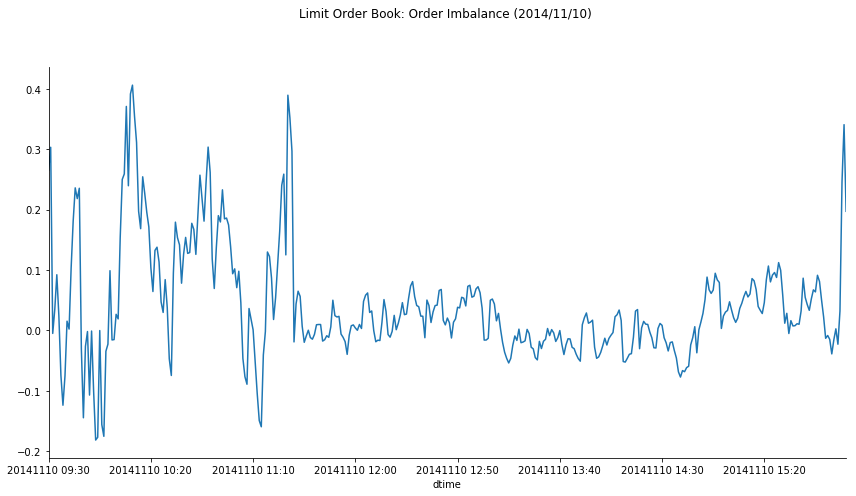

In [11]:
fig1, ax1=plt.subplots(figsize=(12,7))
ins.df['Imb_LOB'][(ins.df.index>='20141110') & (ins.df.index<'20141111')].plot()  
ax1.spines['top'].set_visible(False) 
ax1.spines['right'].set_visible(False)
plt.title('Limit Order Book: Order Imbalance (2014/11/10) \n\n\n') 
plt.tight_layout()  

plt.savefig('./fig/oib_1')

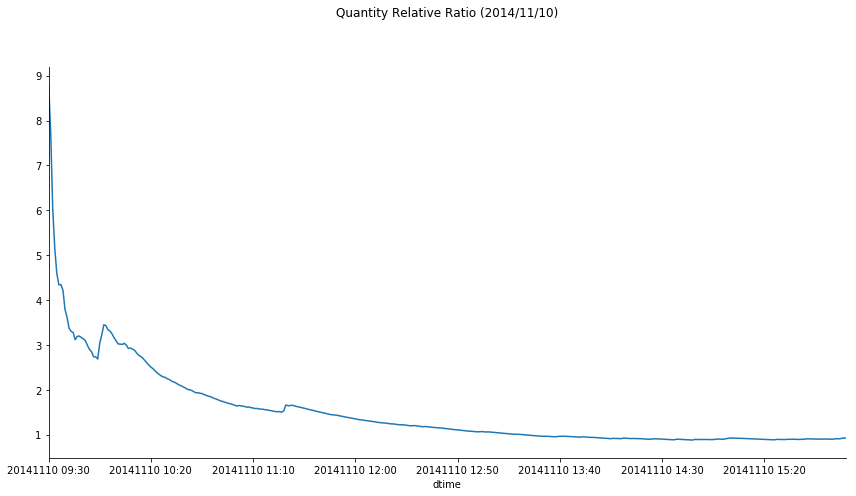

In [12]:
fig1, ax1=plt.subplots(figsize=(12,7))
ins.df['QRR'][(ins.df.index>='20141110') & (ins.df.index<'20141111')].plot()
ax1.spines['top'].set_visible(False) 
ax1.spines['right'].set_visible(False)
plt.title('Quantity Relative Ratio (2014/11/10)\n\n\n') 
plt.tight_layout()  

plt.savefig('./fig/qrr_1')

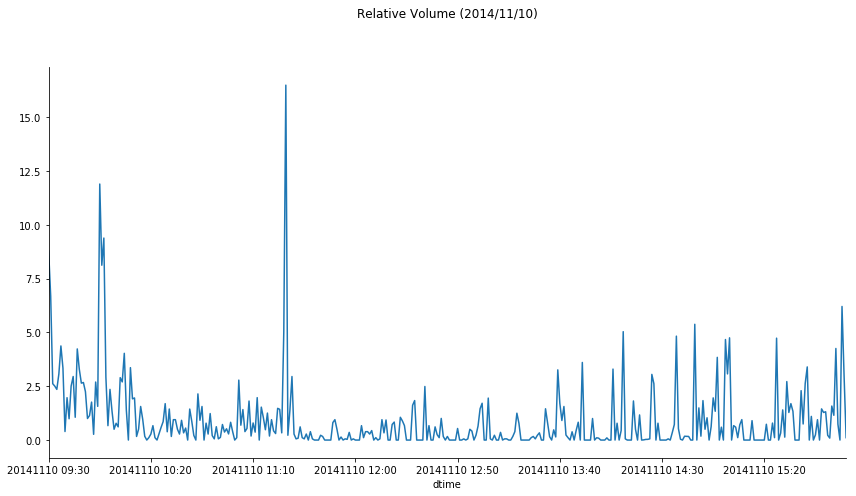

In [13]:
fig1, ax1=plt.subplots(figsize=(12,7))
ins.df['RVol'][(ins.df.index>='20141110') & (ins.df.index<'20141111')].plot()
ax1.spines['top'].set_visible(False) 
ax1.spines['right'].set_visible(False)
plt.title('Relative Volume (2014/11/10)\n\n\n') 
plt.tight_layout()  

plt.savefig('./fig/rvol_1')

---

Market Order Flow Info

---

In [14]:
def dTime(x): 
    '''time stamp milliseconds from midnight at the start of the second'''
    H=str(int(x*0.001/3600))
    M=str(int((x*0.001/3600)%1*60))
    h='0'*(2-len(H))+H
    m='0'*(2-len(M))+M
    return '{}:{}'.format(h,m)
    
#20141110
AnalysisDate='20141110'
data=sco.loadmat('./data/VOD_{}.mat'.format(AnalysisDate))
MO=pd.DataFrame.from_dict(data['LOB'][0][0][7][:,0])  #col 0
MO.columns=['ms']
MO['B/S']=data['LOB'][0][0][7][:,7]
MO['Vol']=data['LOB'][0][0][7][:,6]
MO['Price']=data['LOB'][0][0][7][:,5]*0.0001
MO.index=MO['ms'].apply(dTime)
MO=MO[(MO.index>='09:30') & (MO.index<='16:00')]
MO.head()

,ms,B/S,Vol,Price
ms,,,,
09:30,34200330.0,-1.0,400.0,32.81
09:30,34200355.0,1.0,686.0,32.80
09:30,34200813.0,1.0,600.0,32.81
09:30,34200814.0,1.0,214.0,32.80
09:30,34200818.0,-1.0,200.0,32.81


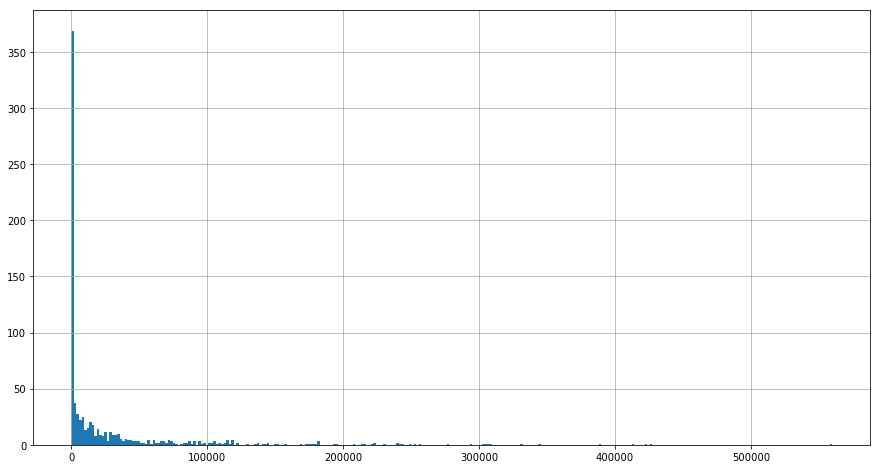

In [15]:
#inter-arrival time: Sell
#exponentially distributed 
MO[MO['B/S']>0]['ms'].diff(1).iloc[10:].hist(bins=300, figsize=(15,8));

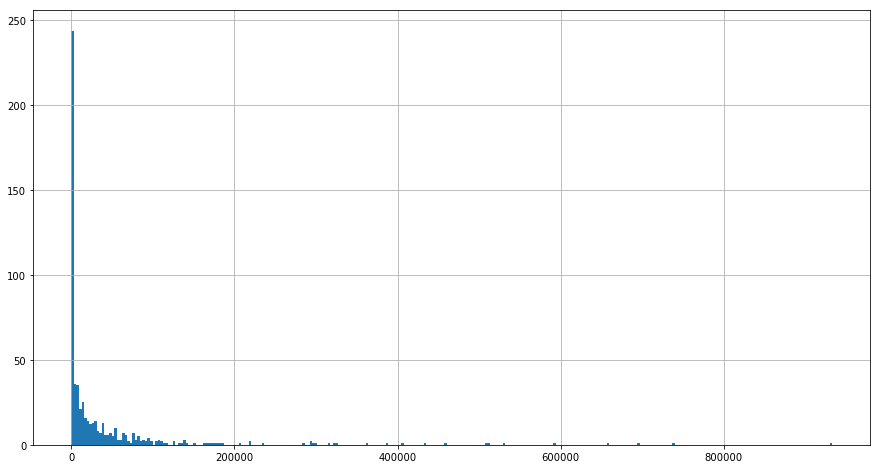

In [16]:
#inter-arrival time: Buy
MO[MO['B/S']<0]['ms'].diff(1).iloc[10:].hist(bins=300, figsize=(15,8));

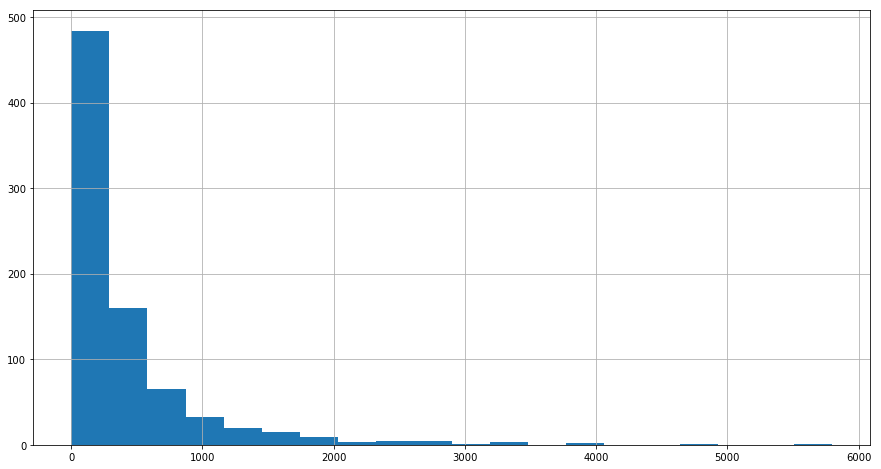

In [17]:
#Sell order 
MO[MO['B/S']>0]['Vol'].hist(bins=20, figsize=(15,8));

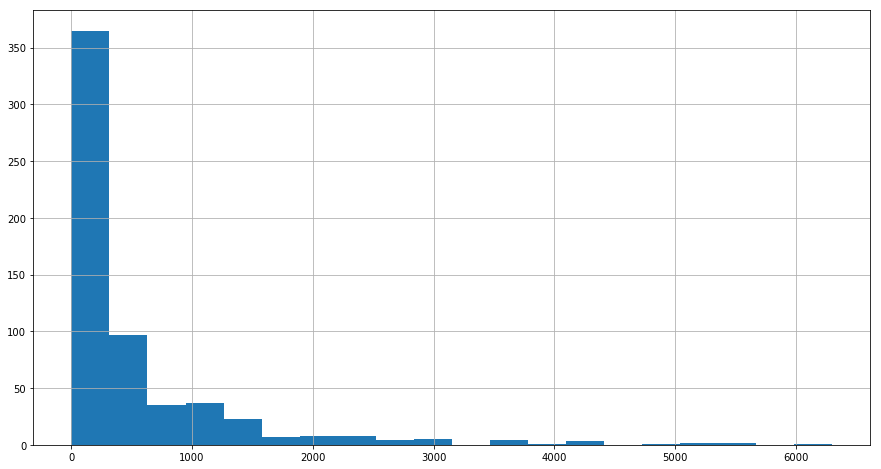

In [18]:
#Buy order 
MO[MO['B/S']<0]['Vol'].hist(bins=20, figsize=(15,8));

---